<h1 align="center"><font size="5">RECOMMENDATION SYSTEM WITH A RESTRICTED BOLTZMANN MACHINE</font></h1>

Welcome to the <b>Recommendation System with a Restricted Boltzmann Machine</b> notebook. In this notebook, we study and go over the usage of a Restricted Boltzmann Machine (RBM) in a Collaborative Filtering based recommendation system. This system is an algorithm that recommends items by trying to find users that are similar to each other based on their item ratings. By the end of this notebook, you should have a deeper understanding of how Restricted Boltzmann Machines are applied, and how to build one using TensorFlow.

<h2>Table of Contents</h2>

<ol>
    <li><a href="#ref1">Acquiring the Data</a></li>
    <li><a href="#ref2">Loading in the Data</a></li>
    <li><a href="#ref3">The Restricted Boltzmann Machine model</a></li>
    <li><a href="#ref4">Setting the Model's Parameters</a></li>
    <li><a href="#ref5">Recommendation</a></li>
</ol>
<br>
<br>
<hr>

<a id="ref1"></a>
<h2>Acquiring the Data</h2>

To start, we need to download the data we are going to use for our system. The datasets we are going to use were acquired by <a href="http://grouplens.org/datasets/movielens/">GroupLens</a> and contain movies, users and movie ratings by these users.

After downloading the data, we will extract the datasets to a directory that is easily accessible.

In [1]:
!apt-get install wget
!wget -c https://raw.githubusercontent.com/IBM/dl-learning-path-assets/main/unsupervised-deeplearning/data/ml-1m.zip -O moviedataset.zip
!unzip -o moviedataset.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
--2021-04-13 23:59:30--  https://raw.githubusercontent.com/IBM/dl-learning-path-assets/main/unsupervised-deeplearning/data/ml-1m.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>]   5.64M  --.-KB/s    in 0.1s    

2021-04-13 23:59:30 (38.5 MB/s) - ‘moviedataset.zip’ saved [5917549/5917549]

Archive:  moviedataset.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  infla

With the datasets in place, let's now import the necessary libraries. We will be using <a href="https://www.tensorflow.org/">Tensorflow</a> and <a href="http://www.numpy.org/">Numpy</a> together to model and initialize our Restricted Boltzmann Machine and <a href="http://pandas.pydata.org/pandas-docs/stable/">Pandas</a> to manipulate our datasets. To import these libraries, run the code cell below.

In [2]:
! pip install pandas
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

<a id="ref2"></a>
<h2>Loading in the Data</h2>

Let's begin by loading in our data with Pandas. The .dat files containing our data are similar to CSV files, but instead of using the ',' (comma) character to separate entries, it uses '::' (two colons) characters instead. To let Pandas know that it should separate data points at every '::', we have to specify the <code>sep='::'</code> parameter when calling the function.

Additionally, we also pass it the <code>header=None</code> parameter due to the fact that our files don't contain any headers.

Let's start with the movies.dat file and take a look at its structure:

In [3]:
#Loading in the movies dataset
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies_df.shape

(3883, 3)

We can do the same for the ratings.dat file:

In [5]:
#Loading in the ratings dataset
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


So our <b>movies_df</b> variable contains a dataframe that stores a movie's unique ID number, title and genres, while our <b>ratings_df</b> variable stores a unique User ID number, a movie's ID that the user has watched, the user's rating to said movie and when the user rated that movie.

Let's now rename the columns in these dataframes so we can better convey their data more intuitively:

In [6]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies_df.shape

(3883, 3)

And our final ratings_df:

In [46]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<hr>

<a id="ref3"></a>
<h2>The Restricted Boltzmann Machine model</h2>

<img src="https://github.com/fawazsiddiqi/recommendation-system-with-a-Restricted-Boltzmann-Machine-using-tensorflow/blob/master/images/films.png?raw=true"  width="300">
<br>
The Restricted Boltzmann Machine model has two layers of neurons, one of which is what we call a visible input layer and the other is called a hidden layer. The hidden layer is used to learn features from the information fed through the input layer. For our model, the input is going to contain X neurons, where X is the amount of movies in our dataset. Each of these neurons will possess a normalized rating value varying from 0 to 1, where 0 meaning that a user has not watched that movie and the closer the value is to 1, the more the user likes the movie that neuron's representing. These normalized values, of course, will be extracted and normalized from the ratings dataset.

After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which in our case, will predict the ratings for movies that user hasn't watched, which is exactly what we can use to recommend movies!

We will now begin to format our dataset to follow the model's expected input.

<h3>Formatting the Data</h3>

First let's see how many movies we have and see if the movie ID's correspond with that value:

In [9]:
len(movies_df)

3883

Now, we can start formatting the data into input for the RBM. We're going to store the normalized users ratings into as a matrix of user-rating called trX, and normalize the values.

In [10]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
user_rating_df.shape

(6040, 3706)

Lets normalize it now:

In [12]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<hr>

<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>

Next, let's start building our RBM with TensorFlow. We'll begin by first determining the number of neurons in the hidden layers and then creating placeholder variables for storing our visible layer biases, hidden layer biases and weights that connects the hidden layer with the visible layer. We will be arbitrarily setting the number of neurons in the hidden layers to 20. You can freely set this value to any number you want since each neuron in the hidden layer will end up learning a feature.

In [13]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Number of unique movies
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Number of features we're going to learn
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is commonly used in RBM's.

In [14]:
v0 = tf.zeros([visibleUnits], tf.float32)
#testing to see if the matrix product works
tf.matmul([v0], W)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [15]:
#Phase 1: Input Processing
#defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state

#printing output of zeros input
h0 = hidden_layer(v0, W, hb)
print("first 15 hidden states: ", h0[0][0:15])

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]


v1 = reconstructed_output(h0, W, vb)
print("hidden state shape: ", h0.shape)
print("v0 state shape:  ", v0.shape)
print("v1 state shape:  ", v1.shape)

first 15 hidden states:  tf.Tensor([1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.], shape=(15,), dtype=float32)
hidden state shape:  (1, 20)
v0 state shape:   (3706,)
v1 state shape:   (3706,)


And set the error function, which in this case will be the Mean Absolute Error Function.

In [16]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

error 0.50053966


Now we train the RBM with 5 epochs with each epoch using a batchsize of 500, giving 12 batches. After training, we print out a graph with the error by epoch.

Epoch: 1 batch #: 0  of 60 sample #: 99 reconstruction error: 0.053394
Epoch: 1 batch #: 1  of 60 sample #: 99 reconstruction error: 0.029520
Epoch: 1 batch #: 2  of 60 sample #: 99 reconstruction error: 0.089271
Epoch: 1 batch #: 3  of 60 sample #: 99 reconstruction error: 0.015262
Epoch: 1 batch #: 4  of 60 sample #: 99 reconstruction error: 0.042267
Epoch: 1 batch #: 5  of 60 sample #: 99 reconstruction error: 0.010210
Epoch: 1 batch #: 6  of 60 sample #: 99 reconstruction error: 0.011182
Epoch: 1 batch #: 7  of 60 sample #: 99 reconstruction error: 0.087555
Epoch: 1 batch #: 8  of 60 sample #: 99 reconstruction error: 0.011247
Epoch: 1 batch #: 9  of 60 sample #: 99 reconstruction error: 0.025537
Epoch: 1 batch #: 10  of 60 sample #: 99 reconstruction error: 0.086800
Epoch: 1 batch #: 11  of 60 sample #: 99 reconstruction error: 0.013222
Epoch: 1 batch #: 12  of 60 sample #: 99 reconstruction error: 0.044263
Epoch: 1 batch #: 13  of 60 sample #: 99 reconstruction error: 0.026476
Ep

Epoch: 2 batch #: 54  of 60 sample #: 99 reconstruction error: 0.019147
Epoch: 2 batch #: 55  of 60 sample #: 99 reconstruction error: 0.089099
Epoch: 2 batch #: 56  of 60 sample #: 99 reconstruction error: 0.011614
Epoch: 2 batch #: 57  of 60 sample #: 99 reconstruction error: 0.007566
Epoch: 2 batch #: 58  of 60 sample #: 99 reconstruction error: 0.051117
Epoch: 2 batch #: 59  of 60 sample #: 99 reconstruction error: 0.098003
Epoch: 2 batch #: 60  of 60 sample #: 39 reconstruction error: 0.074021
Epoch: 3 batch #: 0  of 60 sample #: 99 reconstruction error: 0.018046
Epoch: 3 batch #: 1  of 60 sample #: 99 reconstruction error: 0.005127
Epoch: 3 batch #: 2  of 60 sample #: 99 reconstruction error: 0.090513
Epoch: 3 batch #: 3  of 60 sample #: 99 reconstruction error: 0.013481
Epoch: 3 batch #: 4  of 60 sample #: 99 reconstruction error: 0.033362
Epoch: 3 batch #: 5  of 60 sample #: 99 reconstruction error: 0.006217
Epoch: 3 batch #: 6  of 60 sample #: 99 reconstruction error: 0.008160

Epoch: 4 batch #: 47  of 60 sample #: 99 reconstruction error: 0.059298
Epoch: 4 batch #: 48  of 60 sample #: 99 reconstruction error: 0.008246
Epoch: 4 batch #: 49  of 60 sample #: 99 reconstruction error: 0.111495
Epoch: 4 batch #: 50  of 60 sample #: 99 reconstruction error: 0.179169
Epoch: 4 batch #: 51  of 60 sample #: 99 reconstruction error: 0.022137
Epoch: 4 batch #: 52  of 60 sample #: 99 reconstruction error: 0.082634
Epoch: 4 batch #: 53  of 60 sample #: 99 reconstruction error: 0.005936
Epoch: 4 batch #: 54  of 60 sample #: 99 reconstruction error: 0.021252
Epoch: 4 batch #: 55  of 60 sample #: 99 reconstruction error: 0.092930
Epoch: 4 batch #: 56  of 60 sample #: 99 reconstruction error: 0.009455
Epoch: 4 batch #: 57  of 60 sample #: 99 reconstruction error: 0.007620
Epoch: 4 batch #: 58  of 60 sample #: 99 reconstruction error: 0.050200
Epoch: 4 batch #: 59  of 60 sample #: 99 reconstruction error: 0.107339
Epoch: 4 batch #: 60  of 60 sample #: 39 reconstruction error: 0

Epoch: 6 batch #: 40  of 60 sample #: 99 reconstruction error: 0.005666
Epoch: 6 batch #: 41  of 60 sample #: 99 reconstruction error: 0.011042
Epoch: 6 batch #: 42  of 60 sample #: 99 reconstruction error: 0.013513
Epoch: 6 batch #: 43  of 60 sample #: 99 reconstruction error: 0.009325
Epoch: 6 batch #: 44  of 60 sample #: 99 reconstruction error: 0.007804
Epoch: 6 batch #: 45  of 60 sample #: 99 reconstruction error: 0.078165
Epoch: 6 batch #: 46  of 60 sample #: 99 reconstruction error: 0.039579
Epoch: 6 batch #: 47  of 60 sample #: 99 reconstruction error: 0.059298
Epoch: 6 batch #: 48  of 60 sample #: 99 reconstruction error: 0.009433
Epoch: 6 batch #: 49  of 60 sample #: 99 reconstruction error: 0.114517
Epoch: 6 batch #: 50  of 60 sample #: 99 reconstruction error: 0.178467
Epoch: 6 batch #: 51  of 60 sample #: 99 reconstruction error: 0.018791
Epoch: 6 batch #: 52  of 60 sample #: 99 reconstruction error: 0.086843
Epoch: 6 batch #: 53  of 60 sample #: 99 reconstruction error: 0

Epoch: 8 batch #: 33  of 60 sample #: 99 reconstruction error: 0.068214
Epoch: 8 batch #: 34  of 60 sample #: 99 reconstruction error: 0.020507
Epoch: 8 batch #: 35  of 60 sample #: 99 reconstruction error: 0.108527
Epoch: 8 batch #: 36  of 60 sample #: 99 reconstruction error: 0.015834
Epoch: 8 batch #: 37  of 60 sample #: 99 reconstruction error: 0.025332
Epoch: 8 batch #: 38  of 60 sample #: 99 reconstruction error: 0.104134
Epoch: 8 batch #: 39  of 60 sample #: 99 reconstruction error: 0.017377
Epoch: 8 batch #: 40  of 60 sample #: 99 reconstruction error: 0.006746
Epoch: 8 batch #: 41  of 60 sample #: 99 reconstruction error: 0.012391
Epoch: 8 batch #: 42  of 60 sample #: 99 reconstruction error: 0.013621
Epoch: 8 batch #: 43  of 60 sample #: 99 reconstruction error: 0.008624
Epoch: 8 batch #: 44  of 60 sample #: 99 reconstruction error: 0.004997
Epoch: 8 batch #: 45  of 60 sample #: 99 reconstruction error: 0.085289
Epoch: 8 batch #: 46  of 60 sample #: 99 reconstruction error: 0

Epoch: 10 batch #: 25  of 60 sample #: 99 reconstruction error: 0.019352
Epoch: 10 batch #: 26  of 60 sample #: 99 reconstruction error: 0.097496
Epoch: 10 batch #: 27  of 60 sample #: 99 reconstruction error: 0.023173
Epoch: 10 batch #: 28  of 60 sample #: 99 reconstruction error: 0.098726
Epoch: 10 batch #: 29  of 60 sample #: 99 reconstruction error: 0.024253
Epoch: 10 batch #: 30  of 60 sample #: 99 reconstruction error: 0.020151
Epoch: 10 batch #: 31  of 60 sample #: 99 reconstruction error: 0.046541
Epoch: 10 batch #: 32  of 60 sample #: 99 reconstruction error: 0.099924
Epoch: 10 batch #: 33  of 60 sample #: 99 reconstruction error: 0.068645
Epoch: 10 batch #: 34  of 60 sample #: 99 reconstruction error: 0.020723
Epoch: 10 batch #: 35  of 60 sample #: 99 reconstruction error: 0.105936
Epoch: 10 batch #: 36  of 60 sample #: 99 reconstruction error: 0.017992
Epoch: 10 batch #: 37  of 60 sample #: 99 reconstruction error: 0.025386
Epoch: 10 batch #: 38  of 60 sample #: 99 reconstru

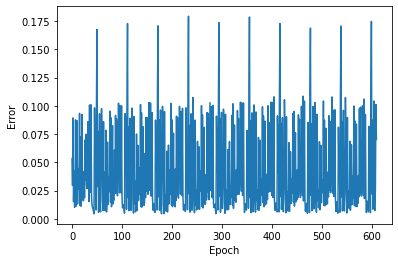

In [17]:
epochs = 10
batchsize = 100
errors = []
weights = []
K=1
alpha = 0.1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)



#for i in range(epochs):
#    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
#        batch = trX[start:end]
#        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        prv_w = cur_w
#        prv_vb = cur_vb
#        prv_hb = cur_hb
#    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
#    print (errors[-1])
v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1), 
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1




plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<hr>

<a id="ref5"></a>
<h2>Recommendation</h2>

We can now predict movies that an arbitrarily selected user might like. This can be accomplished by feeding in the user's watched movie preferences into the RBM and then reconstructing the input. The values that the RBM gives us will attempt to estimate the user's preferences for movies that he hasn't watched based on the preferences of the users that the RBM was trained on.

Lets first select a <b>User ID</b> of our mock user:

In [41]:
mock_user_id = 99

In [42]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)

inputUser = tf.convert_to_tensor(trX[mock_user_id-1],"float32")
v0 = inputUser

print(v0)
v0.shape

tf.Tensor([0.6 0.  0.  ... 0.  0.  0. ], shape=(3706,), dtype=float32)


TensorShape([3706])

In [43]:
v0test = tf.zeros([visibleUnits], tf.float32)
v0test.shape

TensorShape([3706])

In [44]:
#Feeding in the user and reconstructing the input

hh0 = tf.nn.sigmoid(tf.matmul([v0], W) + hb)

vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)

rec = vv1

tf.maximum(rec,1)
for i in vv1:
    print(i)

tf.Tensor([0.40975866 0.0312214  0.00845352 ... 0.00096394 0.00042272 0.01070117], shape=(3706,), dtype=float32)


We can then list the 20 most recommended movies for our mock user by sorting it by their scores given by our model.

In [45]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.808726
2693,2762,"Sixth Sense, The (1999)",Thriller,0.740790
1023,1036,Die Hard (1988),Action|Thriller,0.693900
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.646427
49,50,"Usual Suspects, The (1995)",Crime|Thriller,0.581744
315,318,"Shawshank Redemption, The (1994)",Drama,0.569165
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.549835
1179,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,0.545696
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller,0.520760
453,457,"Fugitive, The (1993)",Action|Thriller,0.506283


So, how to recommend the movies that the user has not watched yet? 

Now, we can find all the movies that our mock user has watched before:

In [48]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock

,UserID,MovieID,Rating,Timestamp
12793,99,3861,3,982873388
12794,99,3793,3,982873215
12795,99,2997,1,982873698
12796,99,1259,5,994353556
12797,99,588,5,982873038
...,...,...,...,...
12895,99,1097,3,994353904
12896,99,709,2,994353411
12897,99,3784,1,982873478
12898,99,3785,4,982873536


In [47]:
movies_df_mock.shape

(34, 4)

In the next cell, we merge all the movies that our mock users has watched with the predicted scores based on his historical data:

In [24]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

lets sort it and take a look at the first 20 rows:

In [25]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.886693,215.0,5.0,976899689.0
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.754768,NaN,NaN,NaN
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.692226,215.0,5.0,976899190.0
2557,2762,"Sixth Sense, The (1999)",Thriller,0.617861,NaN,NaN,NaN
2426,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.551188,215.0,5.0,976908635.0
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.444499,NaN,NaN,NaN
1025,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,0.436541,215.0,5.0,976908468.0
1148,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.433106,NaN,NaN,NaN
971,1036,Die Hard (1988),Action|Thriller,0.396130,NaN,NaN,NaN
1178,1270,Back to the Future (1985),Comedy|Sci-Fi,0.371444,NaN,NaN,NaN


As you can see, there are some movies that user has not watched yet and has high score based on our model. So, we can recommend them to the user.

This is the end of the tutorial. If you want, you can try to change the parameters in the code -- adding more units to the hidden layer, changing the loss functions or maybe something else to see if it changes anything. Optimization settings can also be adjusted...the number of epochs, the size of K, and the batch size are all interesting numbers to explore.
Does the model perform better? Does it take longer to compute?

Thank you for reading this notebook. Hopefully, you now have a little more understanding of the RBM model, its applications and how it works with TensorFlow.

<hr>

## Want to learn more?

You can use __Watson Studio__ to run these notebooks faster with bigger datasets.__Watson Studio__ is IBM’s leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, __Watson Studio__ enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of __Watson Studio__ users today with a free account at [Watson Studio](http://ibm.biz/WatsonStudioRBM).This is the end of this lesson. Thank you for reading this notebook, and good luck on your studies.

### Thank you for completing this exercise!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, Gabriel Garcez Barros Sousa

Updated to TF 2.X by  <a href="https://ca.linkedin.com/in/nilmeier"> Jerome Nilmeier</a><br />

Added to IBM Developer by <a href=https://www.linkedin.com/in/fawazsiddiqi/> Mohammad Fawaz Siddiqi </a> <br/>

<hr>

Copyright &copy; 2020 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).